Hello, my name is Artem. I'm going to review your project!

You can find my comments in <font color='green'>green</font>, <font color='blue'>blue</font> or <font color='red'>red</font> boxes like this:

<div class="alert alert-block alert-success">
<b>Success:</b> if everything is done succesfully
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> "Improve" comments mean that there are tiny corrections that could help you to make your project better.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

### <font color='orange'>General feedback</font>
* I'm glad to say that you executed your project really well.
* There are a couple of things that need to be done before your project is complete, but they're pretty straightforward.
* While there's room for improvement, on the whole, your project is looking good.
* I believe you can easily fix it! Good luck!

### <font color='orange'>General feedback (review 2)</font>
* All your hard work has paid off, and now your project is perfect!
* Model is defined correctly now.
* It would be better if you've used bullet points and bold font (to point out some important parts) in conclusion.
* Keep up the good work. Good luck next!

# Computer Vision - Age Recognition Project

Good Seed is a supermarket chaing that sells alcohol in store. Traditionally, cashiers are tasked with checking identification cards when customers attempt to buy alcohol; this is to avoid selling alcohol to anyone underage. As an extra precaution, Good Seed would like to explore whether machine learning can help them adhere to alcohol laws by automatically scanning customers' faces and predicting their age. For this project, we were asked to conduct such an investigation. Using a set of photographs of peoples' faces and a separate file containing their real ages, we will build, train, and test a convolutional neural network to see if we can create a reliable enough model for the stated purpose. We will start the project by loading the data and performing exploratory data analysis, which includes exploring the age distribution in the dataset and examing a few sample images. We will then use Keras to build and train a ResNet model, which will be tested using a GPU. Finally, we will evaluate the efficacy of our model.

## Initialization

In [3]:
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load and Preprocess the Data

The dataset is stored in the `/datasets/faces/` folder, in which one can find:

- The `final_files` folder.
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`.

Given the fact that there are likely a large number of image files, we will avoid reading them all at once; instead, we will build a generator using ImageDataGenerator and read 16 images at a time. We will also use the flow_from_directory method to match each photo with their corresponding label.

### Load and Examine the Data

In [4]:
#Import labels to DataFrame.
labels = pd.read_csv('/datasets/faces/labels.csv')

#Examine shape of labels DataFrame.
print(f'The "labls" DataFrame has the following shape: {labels.shape}')

The "labls" DataFrame has the following shape: (7591, 2)


In [5]:
#Create data generator to examine images.
exploratory_datagen = ImageDataGenerator()
exploratory_directory = exploratory_datagen.flow_from_dataframe(
    directory='/datasets/faces/final_files/',
    dataframe=pd.read_csv('/datasets/faces/labels.csv'),
    target_size=(250, 250),
    batch_size=16,
    class_mode='raw',
    x_col='file_name',
    y_col='real_age',
    seed=12345)

Found 7591 validated image filenames.


2.1 Notes: In this subsection we loaded the training dataset's labels into a DataFrame and created a data generator which reads the images in the 'final_files' folder in batches of 16. We see that the total number of observations in the 'labels' DataFrame (7591) matches up with the total number of images validated by the data generator. 

### Check for Missing Values in DataFrame

In [6]:
#Check for null values
print(f'Total NaNs in labels file: {labels.isnull().sum().sum()}')

Total NaNs in labels file: 0


### Check for Duplicates

In [7]:
#Print length of labels file
print(f'Total duplicates in labels file: {labels.duplicated().sum()}')

Total duplicates in labels file: 0


### Check Data Types

In [8]:
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


### Data Preprocessing Conclusion

In this section we loaded the data. For the labels, which were contained in a csv file, we loaded them, along with their corresponding file names, into a DataFrame. For the images, in order to ensure that our RAM is not overloaded, we created a data generator that reads the images in batches of 16; the images are also reduced in size to 250x250 pixels.

With regard to the 'labels' DataFrame, we carried out the usual data preprocessing steps, which included checking for missing values and duplicates, as well as checking to ensure the data types are appropriate. We found that the DataFrame contains no missing values, no duplicates, and both columns are appropariately formatted. In the following section, we will carry out some exploratory data analysis. 

<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've remembered about initial analysis of the uploaded file.
</div>

## Exploratory Data Analysis

In this section we will perform some exploratory data analysis. In doing so, we will explore the age distribution in our dataset, as well as print several photos from our dataset with their associated ages in order to get an impression of the dataset.

### Examine Distribution of Ages in Dataset

In [9]:
#Examine statistical info for dataset
print(labels['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


3.1 Notes: From the discription of the data in the 'real_age' column of our DataFrame, we can see that the mean age for individuals in our dataset is approximately 31. The age range contained in the dataset is between 1 and 100, which covers all ages one would expect to find in a store. It also appears that the bulk of images we have to work with are for individuasl who are between the ages of 20 and 41. Let us plot the distribution of ages to visualize these findings.

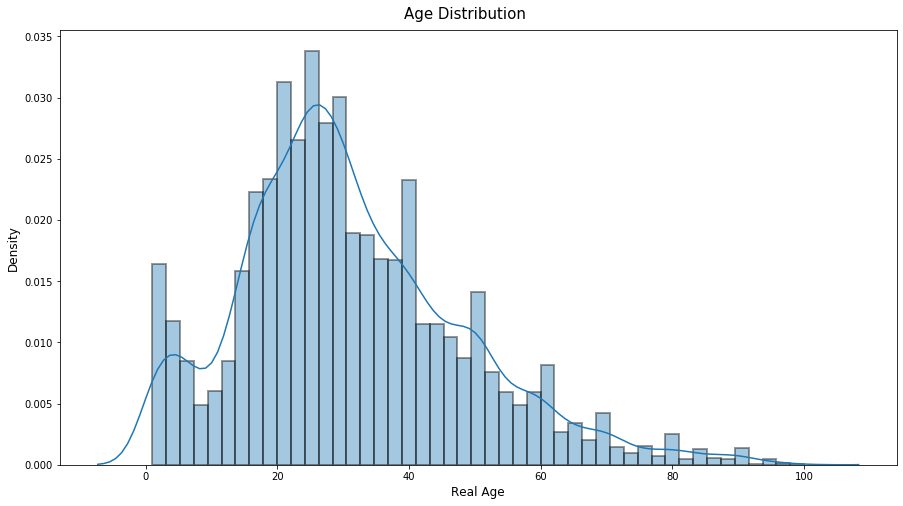

In [10]:
#Create displot to visualize age distribution.
fig = plt.figure(figsize=(15, 8))
plt.suptitle('Age Distribution', fontsize=15, y=.92)
sns.distplot(labels['real_age'], hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel('Real Age', fontsize=12)
plt.ylabel('Density', Fontsize=12)
plt.show()

3.1 Continued: From this distplot, which is a combination of a hitogram and kernel density estimator, we see that the majority of observations are for individuals around the age of 30. After the mean, which we found to be 31, the number of individuals for each age group tends to decrease smoothly, with the fewest individuals being aged between around 95 and 100. Oddly, there is an abundance of images for individuals aged between 1 and 5. To better conceptualize the age distribution, let us categorize ages into 4 bins: those under 21, those between 21 and 40, those between 40 and 60, and those between 60 and 100. 

In [11]:
#Create function to categorizing individuals by age group.
def categorize(x):
    if x <= 20:
        return '0-20'
    elif 40 >= x > 20:
        return '21-40'
    elif 60 >= x > 40:
        return '40-60'
    else:
        return '60-100'
    
#Categorize individuals by age group.
category = labels.copy()
category['group'] = category['real_age'].apply(categorize)

#Obtain percentage for each age group.
grouped_category = category.groupby('group')['real_age'].count().to_frame(name='total_grouped').reset_index()
grouped_category['percentage'] = ((grouped_category['total_grouped'] / 
                                   grouped_category['total_grouped'].sum()) * 100).round(2)

#Display percentages for age groups.
display(grouped_category.set_index('group'))

,total_grouped,percentage
group,,
0-20,2054,27.06
21-40,3628,47.79
40-60,1463,19.27
60-100,446,5.88


3.1 Continued: From the above DataFrame, we can see that the majority of our observations are for individuals between the ages of 21 and 40. The second largest age group is comprised of individuals between the ages of 0 and 21. While we don't expect that very young children will be visiting the grocery stores alone, it is good to have a large number of samples for individuals aged under 21, as our model's intended use will be to ensure that underaged individuals do not purchase alcohol. While it may not seem necessary for our model to be trained on images of very young children, the importance lies in the fact that individuals may bring their young children along grocery shopping, so it is important that our model has a basis for discerning very young children from those individuals who may appear young and who may be nearly 21. Finally, we see that approximately 20% of our dataset is comprised of individuals between the ages of 40 and 60, and less that 6% is made of up individuals between 60 and 100, inclusively. While we do not have as many images of individuals between 40 and 100 as we do of those between 0 and 40, this should not be of great concern to us given the goal of this project, as we believe such individuals will reliably be identified as being of some age over 21. 

<div class="alert alert-block alert-success">
<b>Success:</b> The distribution was visualiezed in the right way.
</div>

In [12]:
#Select features and target from our image generator directory.
features, target = next(exploratory_directory)

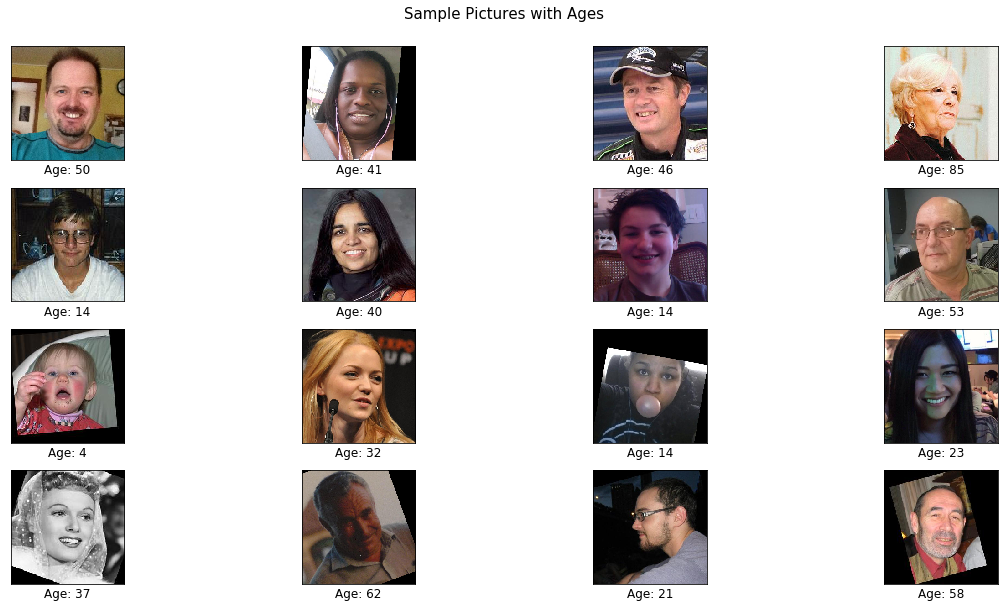

In [13]:
#Create figure to plot images.
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Sample Pictures with Ages", fontsize=15, y=1.05)

#Loop through images and print each with their relevant age.
for image in range(16):
    array = np.array(features[image])
    array = array/255
    axs=fig.add_subplot(4, 4, image+1)
    
    #Add age for each individual.
    axs.set_xlabel(f'Age: {target[image]}', fontsize=12)
    
    #Remove x and y ticks.
    axs.set_xticks([])
    axs.set_yticks([])
    plt.imshow(array)
plt.tight_layout()

3.2 Notes: The above images represent the first set of 16 images from our image data generator. From appearances, each image is printed along with it's appropriate age. That being the case, we can be confident that our image data generator functions properly and properly assigns targets to their relevant photos.

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see that ages were printed.
</div>

### Exploratory Data Analysis Conclusion

In this section we carried out exploratory data analysis on our datasets. In doing so, we visualized the distribution of ages contained in the sets and printed a sample 16 images along with their associated age. In carrying out this analysis, we've come to the following conclusions:

* The mean age for individuals in our dataset is approximately 31, and the age range contained in the dataset is between 1 and 100. 

* After around 31, which is the mean age in our dataset, the number of individuals for each age group tends to decrease smoothly, with the fewest individuals being aged between around 95 and 100. 

* There is an abundance of images for individuals aged between 1 and 5. This is not a bad thing, as some parents will undoubtedly bring their young children into the store, and it would be beneficial for our model to be able to distinguish between such young children and young adults.

* After separating our dataset into four groups (i.e., 0-21, 21-40, 40-60, 60-100), we found that the majority of our observations are for individuals between the ages of 18 and 40, with the second largest age group comprised of individuals between the ages of 0 and 21. 

Overall, we are happy with the distribution of ages. While there are fewer individuals at the high end of the spectrum, we find this acceptable for two reasons. First, they represent a smaller demographic of shoppers. Second, our model's purpose is to aid in determining whether an individual is too young to purchase alcohol; for this reason, we'd want a larger portion of images for individuals around the legal drinking age, which is what we have. While our later model might not be able to effectively predict the ages of individuals on the higher end of the spectrum, because there are fewer photos of that demographic, we believe it would do a good job of predicting the age of individuals near the legal drinking age, given the distribution of ages in the dataset.

In the following section, we will build, train, and test a ResNet50 model to predict the ages of individuals based on photos.

<div class="alert alert-block alert-success">
<b>Success:</b> Analysis was done well. It was a good idea to structure comments with bullet points.
</div>

## Create Model and Necessary Functions

In this section we will be creating a number of functions that will be used for model development. The purposes of the functions are as follows:

* Function 1: Load training data.

* Function 2: Load testing (or validation) data.

* Function 3: Create a convolutional neural network.

* Function 4: Train the model.

### Create Function to Load Training Data

In [14]:
#Function to load training data.
def load_train(path):
    """
    This function loads the training part of the dataset from the specified path.
    """
    datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=.25)
    
    #Use flow from dataframe to import images and appropriate labels.
    train_gen_flow = datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=pd.read_csv(path + 'labels.csv'),
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        x_col='file_name',
        y_col='real_age',
        seed=12345)

    return train_gen_flow

### Create Function to Load Testing Data

In [15]:
#Function to load testing data.
def load_test(path): 
    """
    This function loads the testing part of the dataset from the specified path.
    """
    datagen = ImageDataGenerator(rescale=1./255)
    
    #Use flow from dataframe to import images and appropriate labels.
    test_gen_flow = datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=pd.read_csv(path + 'labels.csv'),
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        x_col='file_name',
        y_col='real_age',
        seed=12345)

    return test_gen_flow

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Augmentation should be applied only to train set. Please measure the quality on the real data (w/o augmentations).
    
<b>Response:</b> Thanks for catching these things. I've fixed my loading function and removed the vertical flip augmentation.
</div>



<div class="alert alert-block alert-info">
<b>Improve: </b> Vertical flip do not make sense because it generates rotated images.
</div>

### Create Function to Define and Compile Model

In [16]:
#Function to create model.
def create_model(input_shape):
    """
    This function defines and compiles our model.
    """
    #Define ResNet50 as backbone. Remove top layers.
    backbone = ResNet50(input_shape=(150, 150, 3), weights='imagenet', include_top=False)

    #Define model.
    model = Sequential([
    backbone,
    GlobalAveragePooling2D(),
    Dense(12, activation='relu'),
    Dense(1, activation='relu')])

    #Compile model.
    model.compile(
        optimizer=Adam(lr=.001),
        loss='mae',
        metrics=['mae'])

    return model

### Create Function to Train Model

In [18]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
    validation_data=test_data,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2)

    return model

### Model and Function Creation Summary

In this section we created a number of funtions central to building and training our convolutional neural network. The first two functions load the training and testing datasets. Since we have too many images to simply store on RAM, we used an image data generator to load images in batches of 16. In doing so, we also specified several augmentations to be carried out on the images and reduced the pixel sizes to 150x150.

Regarding the function that creates and compiles our model, we specified that the majority of the model will follow the ResNet50 architecture; we only removed the top of the model in order to add out own layers. When compiling the model, we used the Adam optimizer with a learning rate of .001 and used MAE for both the loss function and evaluation metric.

Our final function trains the model on the training dataset and uses the test data for validation. We set the number of epochs to 20; ideally we would like to run more, but in order to conserve time and resources, we felt that 20 was an appropriate number of epochs.

In the next section, we prepare a script to execute our functions and train/evaluate our model on Yandex's GPU platform.

## Prepare Script to Run on the Yandex GPU Platform

After creating the above functions, we will not create a script with the functions in order to run our program on Yandex's GPU platform. We will then run the script on their platform and paste the results of our model's training into a subsequent cell.

When create our script, we start by adding a long string which is meant to import all the relevant libraries and modules for training our model. We then create a file and write our import statements to it, along with our functions.

In [19]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

We submitted the file that was output by the above cell (i.e., run_model_on_gpu.py) to the Yandex GPU platform and  pasted the training and validation sets' mean absolute errors for each epoch below.

Train for 356 steps, validate for 119 steps

Epoch 1/20

2021-08-19 12:37:30.859848: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2021-08-19 12:37:31.174847: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 45s - loss: 260.2839 - mae: 11.8298 - val_loss: 490.6014 - val_mae: 17.0055

Epoch 2/20

356/356 - 36s - loss: 118.8604 - mae: 8.2253 - val_loss: 188.2047 - val_mae: 10.3036

Epoch 3/20

356/356 - 35s - loss: 93.7831 - mae: 7.4002 - val_loss: 192.1293 - val_mae: 10.9365

Epoch 4/20

356/356 - 35s - loss: 74.7336 - mae: 6.6016 - val_loss: 99.8093 - val_mae: 7.4662

Epoch 5/20

356/356 - 35s - loss: 61.2775 - mae: 5.9969 - val_loss: 126.7901 - val_mae: 8.2667

Epoch 6/20

356/356 - 35s - loss: 54.6650 - mae: 5.6253 - val_loss: 111.8150 - val_mae: 8.0362

Epoch 7/20

356/356 - 35s - loss: 46.7774 - mae: 5.2492 - val_loss: 88.9159 - val_mae: 7.3049

Epoch 8/20

356/356 - 36s - loss: 41.4468 - mae: 4.8811 - val_loss: 99.6786 - val_mae: 7.3732

Epoch 9/20

356/356 - 35s - loss: 36.0747 - mae: 4.5857 - val_loss: 87.1122 - val_mae: 6.9876

Epoch 10/20

356/356 - 35s - loss: 30.7393 - mae: 4.2403 - val_loss: 78.8586 - val_mae: 6.7305

Epoch 11/20

356/356 - 35s - loss: 27.6634 - mae: 4.0253 - val_loss: 79.2080 - val_mae: 6.5764

Epoch 12/20

356/356 - 36s - loss: 26.2344 - mae: 3.8508 - val_loss: 90.1072 - val_mae: 7.0437

Epoch 13/20

356/356 - 36s - loss: 23.6925 - mae: 3.7371 - val_loss: 81.8165 - val_mae: 6.8021

Epoch 14/20

356/356 - 36s - loss: 21.3308 - mae: 3.4904 - val_loss: 84.9309 - val_mae: 6.7948

Epoch 15/20

356/356 - 35s - loss: 19.5359 - mae: 3.4179 - val_loss: 135.9364 - val_mae: 8.9805

Epoch 16/20

356/356 - 35s - loss: 17.7645 - mae: 3.2027 - val_loss: 110.5504 - val_mae: 8.2450

Epoch 17/20

356/356 - 35s - loss: 16.8798 - mae: 3.1300 - val_loss: 78.4753 - val_mae: 6.5252

Epoch 18/20

356/356 - 35s - loss: 17.3177 - mae: 3.1430 - val_loss: 80.6793 - val_mae: 6.7540

Epoch 19/20

356/356 - 35s - loss: 17.1261 - mae: 3.1208 - val_loss: 106.0266 - val_mae: 7.4396

Epoch 20/20

356/356 - 36s - loss: 16.3323 - mae: 3.0980 - val_loss: 74.2701 - val_mae: 6.3732

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 9s - loss: 76.0105 - mae: 6.4858

Test MAE: 6.4858


### Model Training Conclusion

From our above prinout, we can see that our model performed far better than the maximum allowable threshold. Recall that Good Seed requres that our model's mean absolute error for the test set be less than 8; that is, the average difference between a predicted age and an individual's actual age can be no greater than 8 years.

After 20 epochs, we found that our model's MAE for the testing dataset is approximately 6.5, which is about 1.5 years lower than the maximum allowable limit. As such, Good Seed should be satisfied with the current version of the model, though improvements are possible,

## Conclusions

The aim of this project was to develope a model for Good Seed that is able to determine an individuals age from an image with a MAE of no greater than 8. In developing this model, we first performed exploratory data analysis to visualize the distribution of ages in the dataset. We found that the mean age for individuals in the set is approximately 31, and that the majority of individuals fall between the ages of 18 and 40, among other things. Next, we created functions to aid in defining, developing, and training a ResNet50 model with custom top layers. In order to ensure training efficiency, we set the number of epochs for the model to 20 and used Adam as the optimizer, with a learning rate of .0001. Overall, we found that our model performed quite well and meets Good Seed's requirements - that is, it's MAE for the testing dataset is approximately 6.5, which is lower than the specified threshold. 

While we developed a model that meets Good Seed's requirements, we believe that Good Seed should consider a classification model rather than a regression one. As we understood it, the end-goal of this endeavor is to have a model that will aid Good Seed employees in ensuring that no one under the legal drinking age can buy alcohol. As we saw, our model's MAE is under the threshold specified by Good Seed; however, it is not small enough to be confident that the model will identify all those who are under the legal drinking age. We believe that Good Seed's purpose can better be achived by using a model that categorizes individuals as either underage or of appropriate age. We would also suggest that in training such a model, developers ensure that there is a higher perportion of images for 'boarderline' ages (those for individuals who are 1-2 years below and 1-2 years above the legal drinking age) than for other individuals. If the model can, to a high degree, differentiate between individuals specifically below the legal drinking age and above, then we believe Good Seed would find it more useful than the one currently developed.

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Probably you've sent not the last version of the project.

<b>Student Response:</b> I'm sorry, I have no idea what happened there. I saved the file properly, but somehow a good portion of the project was lost. I've uploaded all the missing information.

</div>



# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training